# Females diabetes preiction project

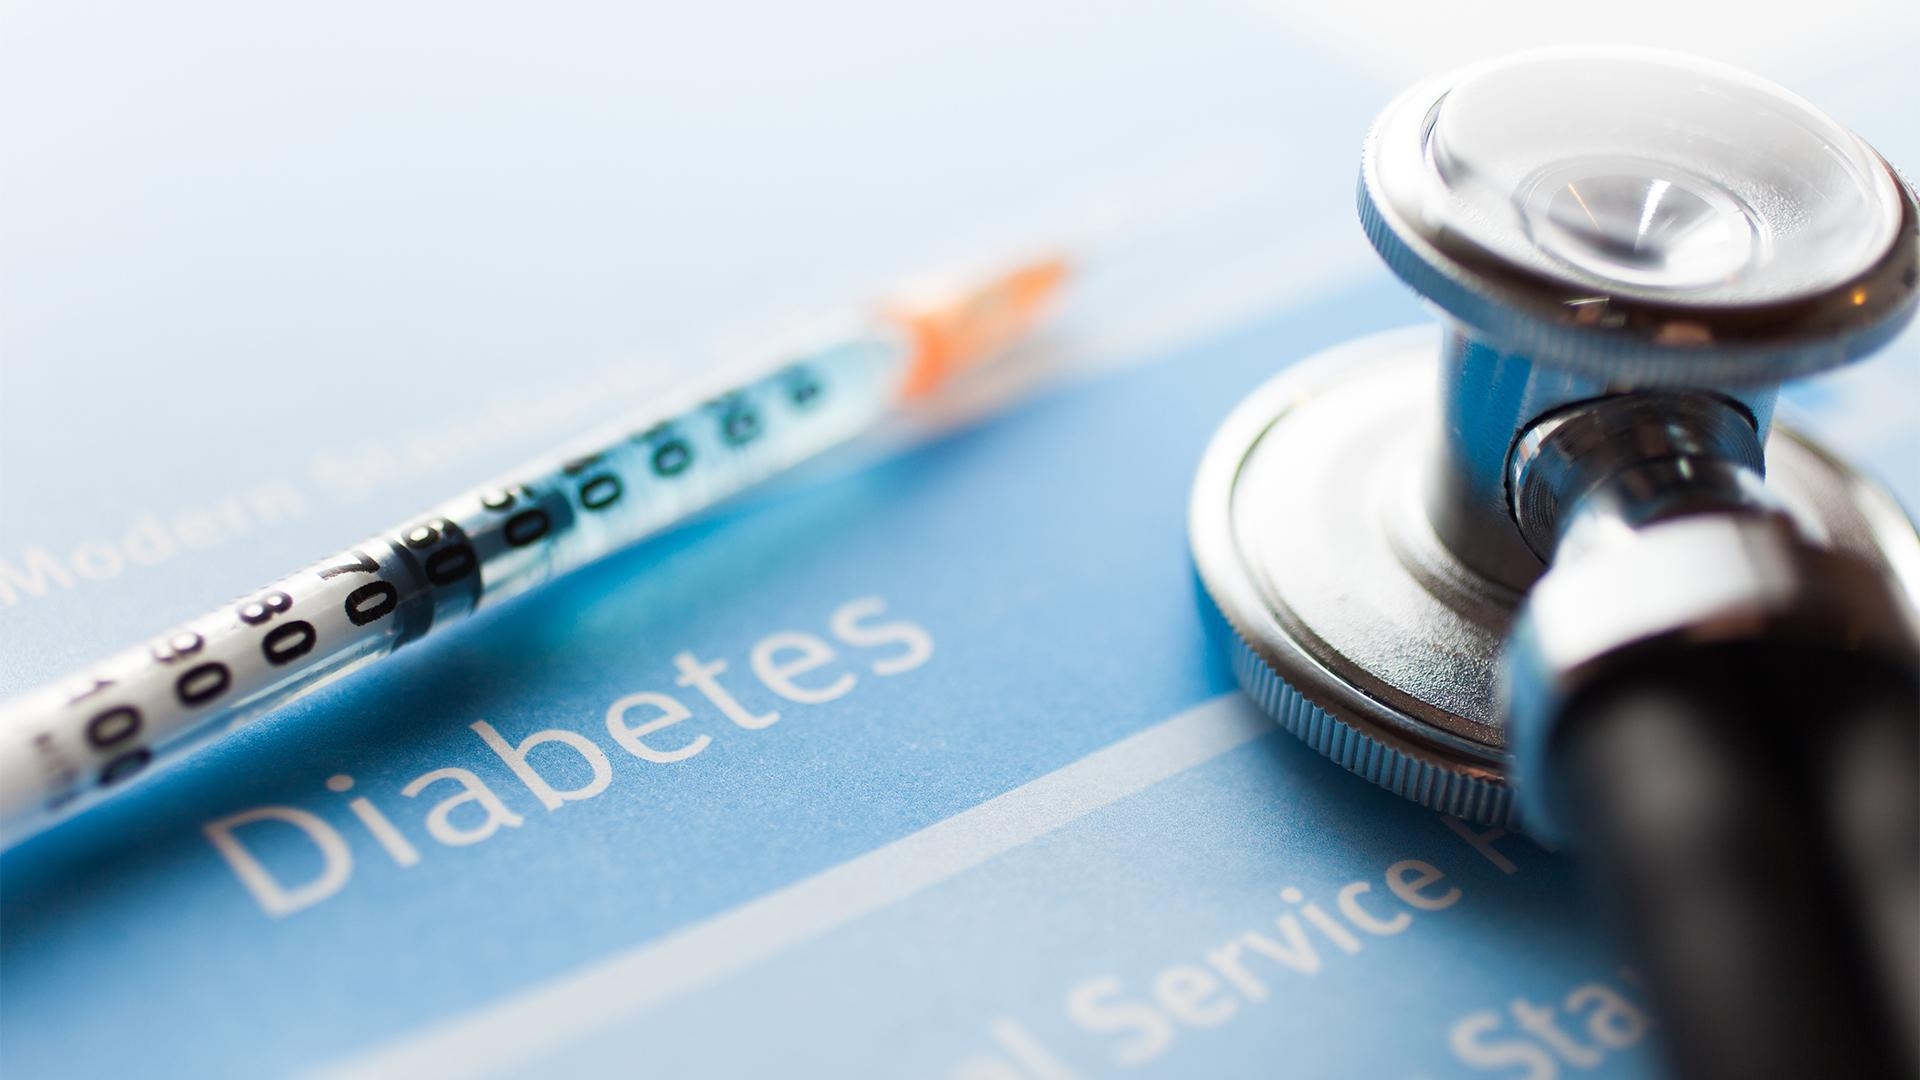

In this classification problem we create a model with custom pipelines that predicts the probability of females having diabetes. For this project we had some imbalance in the data, so we consider ``recall score`` rather than Accuracy Score.
* At last we got a very good Test Data **Recall Score = 87.234 %** with ``Random Forest Classifier``.

The entire Architecture of this notebook -
## Contents

1.	[Load Data](#load)
2.	[KNN imputer for missing data](#knn_impute)
3.	[Feature Engineering](#FEngineering)
4.  [Model Selection and Hyper Parameter Tuning](#model)
5.  [Feature Selection and Model Evaluation](#feature)
6.  [Model Goodness Check using ROC Curve](#roc)
7.	[Pipeline Creation For Prediction](#pipeline)
8.  [It's Run Time](#run)

<a id="load"></a>
## 1) Load Data 
* Load Diabetes Data.

In [1]:

import pandas as pd
df = pd.read_csv('datasets/diabetes.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
data = df.copy()
print("Diabetes data set dimensions : {}".format(data.shape))

Diabetes data set dimensions : (768, 9)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

* So there is ``no Null`` values from the dataset.

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

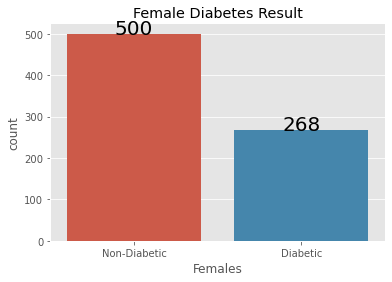

In [6]:
ax_count = sns.countplot(x = 'Outcome', data= data);
ax_count.set_title('Female Diabetes Result')
ax_count.set_xlabel('Females')
ax_count.set_xticklabels(['Non-Diabetic', 'Diabetic'])

for p in ax_count.patches:
    height = p.get_height()
    ax_count.text(x = p.get_x() + p.get_width()/2, y = height + 0.005, s= '{}'.format(height),fontsize = 20,  ha="center") 
    
plt.show()

In [7]:
data.iloc[:, -1].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

Now we extract features which has 0's as values except for first and last feature

In [8]:
data_col = data.columns[1: -1]
features = []
for col in data_col:
    if((data[col].unique() == 0).any()):
        features.append(col)
features        

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

* In reality we can't have ``zero's`` for **Glucose, BloodPressure, SkinThickness, Insulin, BMI** for diabetes prediction.

<a id="knn_impute"></a>
### 2) KNN imputer for missing data
* Visit ``Missing Data Imputaion using KNN`` notebook get to know how right parameters are selected and used in this notebook.

In [9]:
import numpy as np

In [10]:
X = data.drop(columns = 'Outcome')
Y = data['Outcome']

In [11]:
#replace with np.nan to all features which has 0's
filt_0 = X[features] == 0
X[filt_0] = np.nan

In [12]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [13]:
np.dtype(X['Glucose'])

dtype('float64')

In [14]:
X.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score


In [17]:
DTC_Mod = DecisionTreeClassifier(random_state= 0)

In [18]:
knn_Imp = KNNImputer(n_neighbors=45)
knn_Imp_X = knn_Imp.fit_transform(scaled_X)
inv_scaled_X = scaler.inverse_transform(knn_Imp_X)
knn_Imp_X = pd.DataFrame(inv_scaled_X, columns = X.columns)
cols = [col for col in X.columns if col not in ['BMI', 'DiabetesPedigreeFunction']]
knn_Imp_X[cols] = np.where(knn_Imp_X[cols] > (knn_Imp_X[cols].astype(int) + 0.5), knn_Imp_X[cols].apply(np.ceil), knn_Imp_X[cols].apply(np.floor))
knn_Imp_X[cols] = knn_Imp_X[cols].astype(int)


print("Cross Validation Recall Score = {}.".format(cross_val_score(DTC_Mod, knn_Imp_X, Y, cv=10, scoring = 'recall').mean()))

Cross Validation Recall Score = 0.6531339031339031.


In [19]:
knn_Imp_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,213,33.6,0.627,50
1,1,85,66,29,72,26.6,0.351,31
2,8,183,64,29,214,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [20]:
knn_Imp_X.isna().sum()
#No nan values are persent.

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

<a id="FEngineering"></a>
## 3) Feature Engineering
* Visit ``Feature Engineering`` notebook get to know how right parameters are selected and used in this notebook.

Here we perform Feature Engineering Techniques such as 

3.a.  [Outliers Handling](#outlier)

3.b.  [Gaussian Transformation](#Gaussian)

<a id="outlier"></a>
### 3.a) Outliers Handling

In [21]:
data = knn_Imp_X.copy()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,213,33.6,0.627,50
1,1,85,66,29,72,26.6,0.351,31
2,8,183,64,29,214,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [22]:
outlier_df = pd.DataFrame(data.columns, columns = ['Columns'])
outlier_df

,Columns
0,Pregnancies
1,Glucose
2,BloodPressure
3,SkinThickness
4,Insulin
5,BMI
6,DiabetesPedigreeFunction
7,Age


In [23]:
for i, col in enumerate(data.columns):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    outlier_df.loc[i, 'Lower_Bound'] = data[col].quantile(0.25)-(IQR*1.5)
    outlier_df.loc[i, 'Upper_Bound'] = data[col].quantile(0.75)+(IQR*1.5)
outlier_df

,Columns,Lower_Bound,Upper_Bound
0,Pregnancies,-6.50,13.50
1,Glucose,39.00,201.00
2,BloodPressure,40.00,104.00
3,SkinThickness,6.50,50.50
4,Insulin,-47.50,332.50
5,BMI,13.85,50.25
6,DiabetesPedigreeFunction,-0.33,1.20
7,Age,-1.50,66.50


In [24]:
#function for outlier handling.e

def Outlier_Handling(data):
    for i, col in enumerate(data.columns):
        if col == 'BloodPressure':
            data[col] = np.where(data[col] <= outlier_df.loc[i, 'Lower_Bound'], outlier_df.loc[i, 'Lower_Bound'].astype(int), data[col])
            data[col] = np.where(data[col] >= outlier_df.loc[i, 'Upper_Bound'], outlier_df.loc[i, 'Upper_Bound'].astype(int), data[col])
        elif col not in ['BMI', 'DiabetesPedigreeFunction']:
            data[col] = np.where(data[col] >= outlier_df.loc[i, 'Upper_Bound'], outlier_df.loc[i, 'Upper_Bound'].astype(int), data[col])
        else:
            data[col] = np.where(data[col] >= outlier_df.loc[i, 'Upper_Bound'], outlier_df.loc[i, 'Upper_Bound'], data[col])
    
    return  data

In [25]:
data = Outlier_Handling(data)

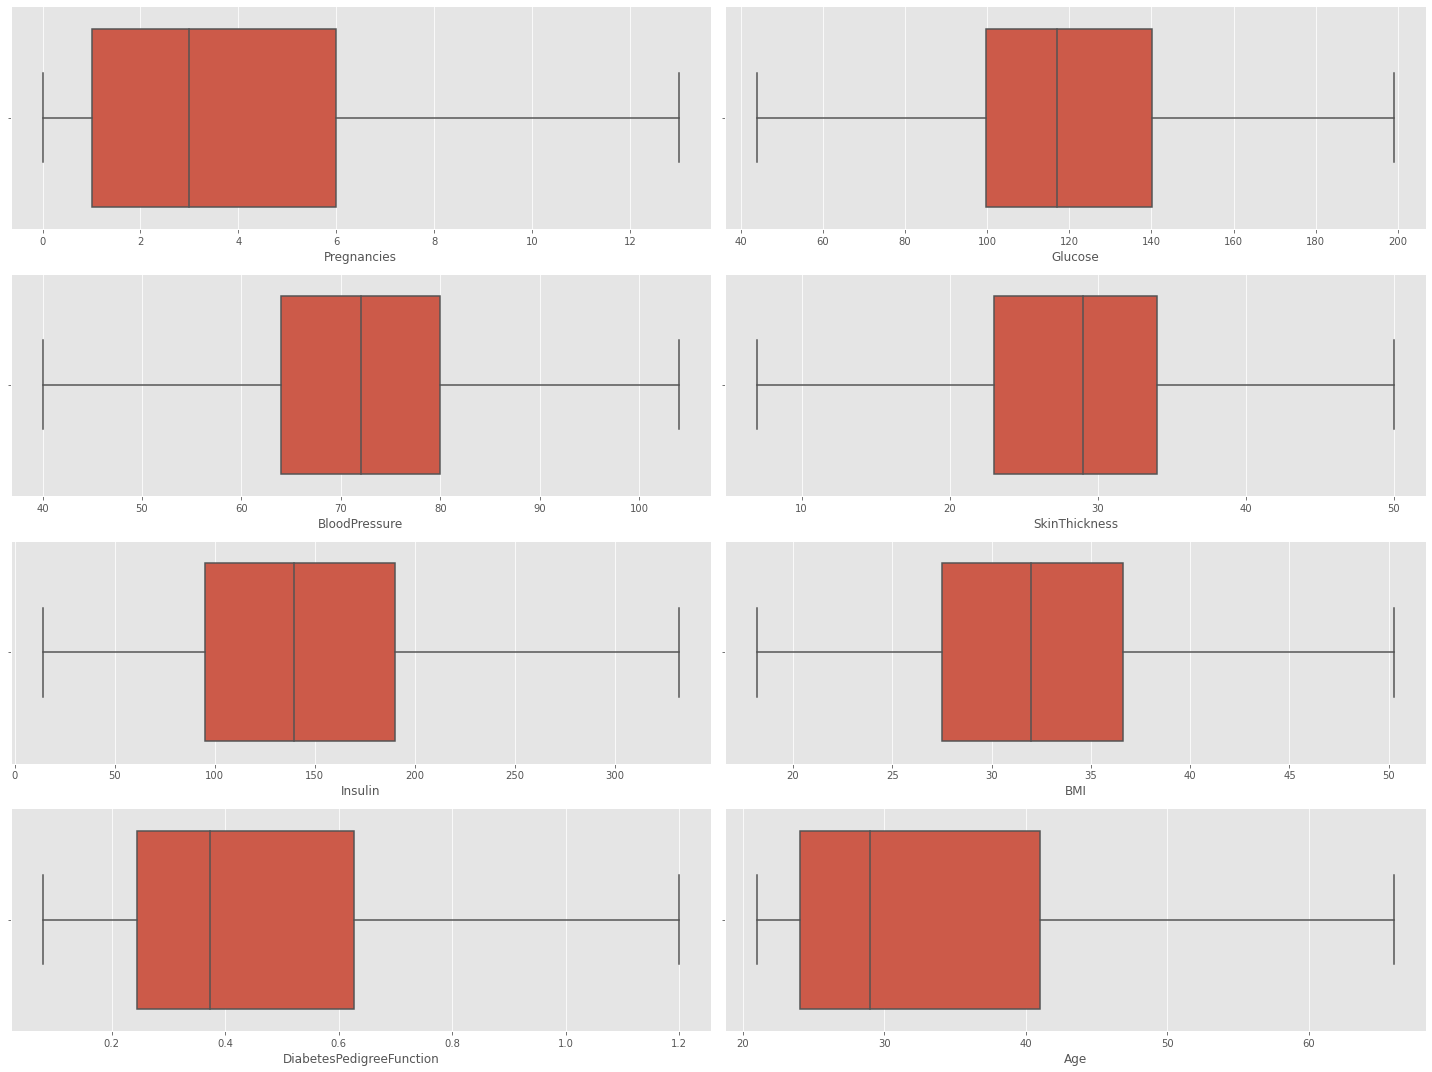

In [26]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20, 15))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i, col in enumerate(data.columns):
    sns.boxplot(x= data[col], ax= ax[i])
    
plt.tight_layout()

<a id="Gaussian"></a>
### 3.b) Gausian Transformation

In [27]:
columns = data.columns

In [28]:
import scipy.stats as stats
plt.style.use('ggplot')

###### Q-Q plot Function

**Q-Q**(quantile-quantile) Plot is better for visualizing whether feature is ``Gausian Distribution`` or not.

In [29]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1) 
    sns.distplot(df[variable])
    
    # Displaying Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()
    


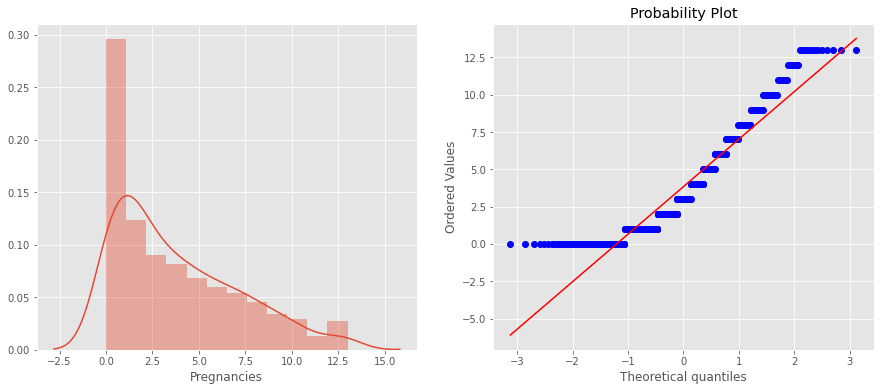

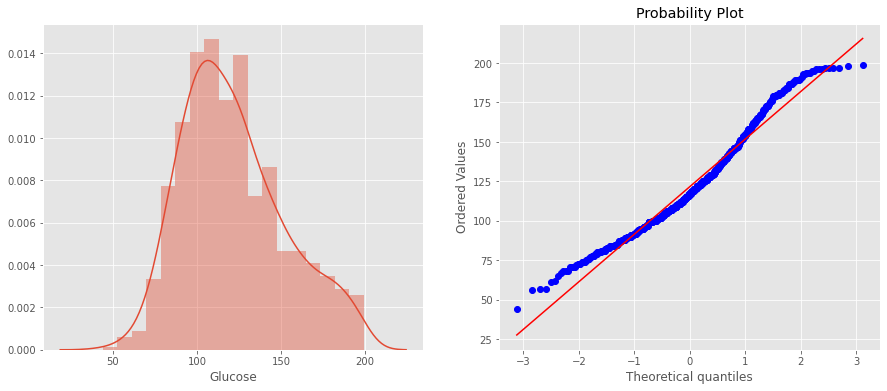

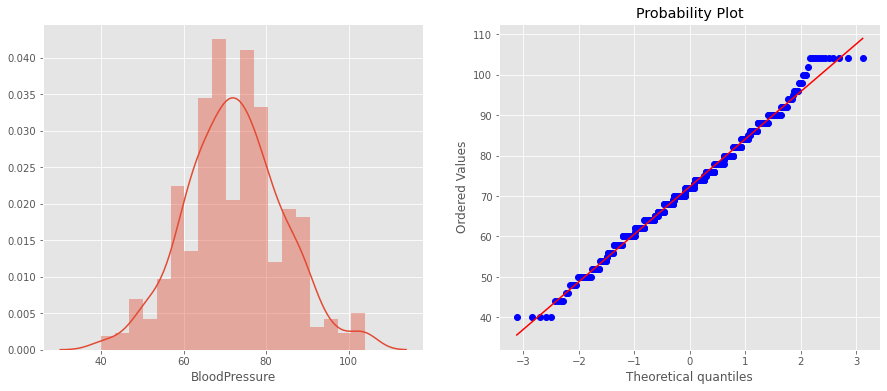

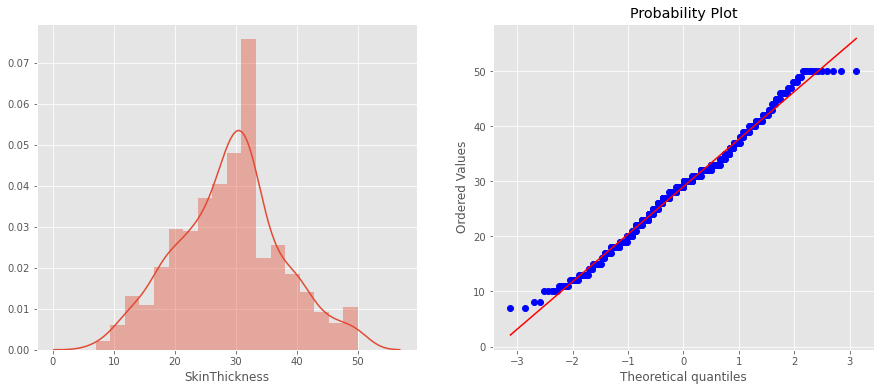

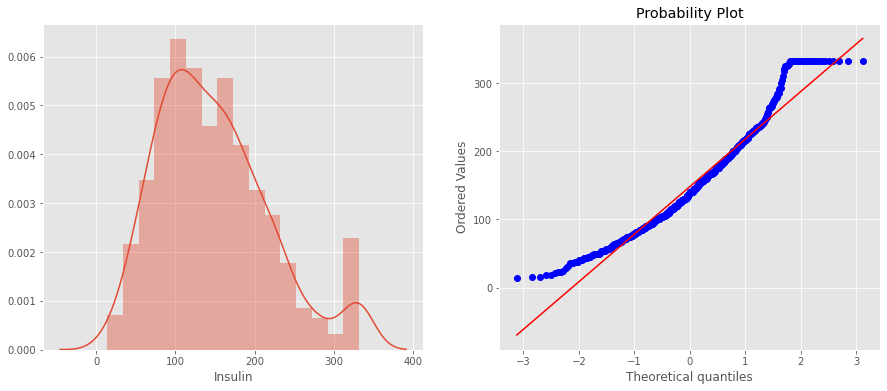

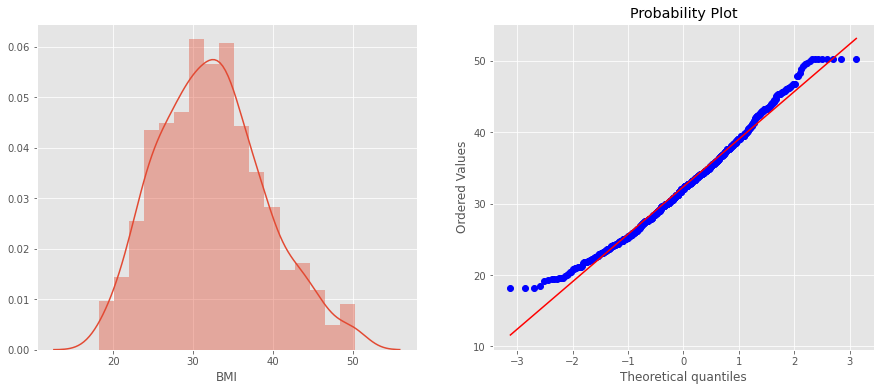

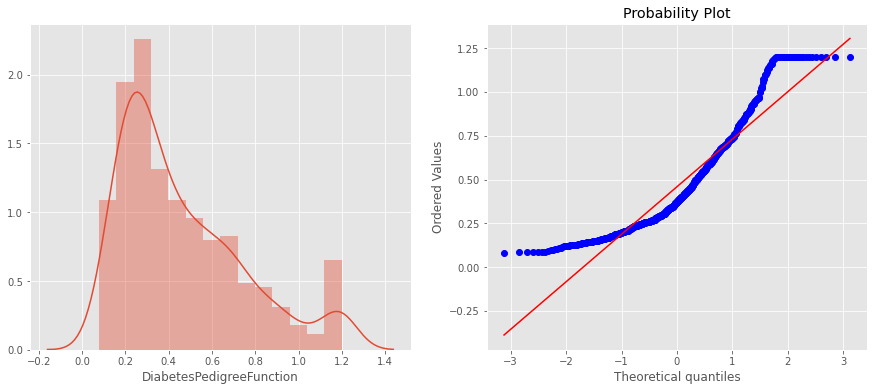

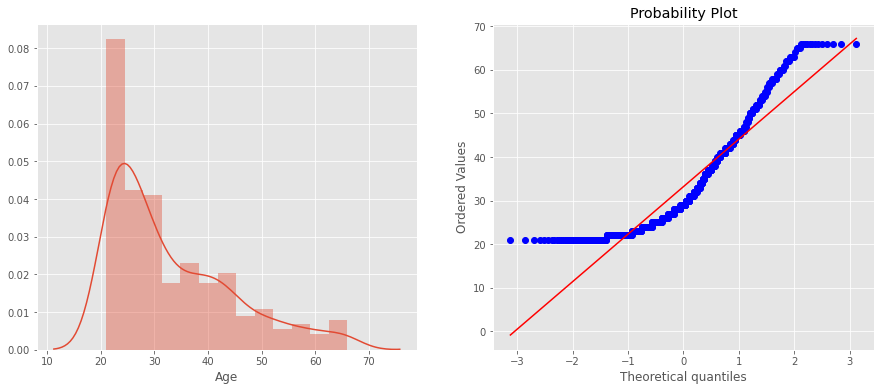

In [30]:
for col in data.columns:
    diagnostic_plots(data, col)

#### Yeo-Johnson Transform

In [31]:
from sklearn.preprocessing import PowerTransformer

In [32]:
power = PowerTransformer(method = 'yeo-johnson', standardize= False)
data_trans = power.fit_transform(data)
data = pd.DataFrame(data_trans)
data.columns = columns
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.330737,6.205037,36.329902,27.149304,20.023718,5.605497,0.310087,0.870964
1,0.738299,5.390749,33.865339,22.854380,11.929581,5.087564,0.225562,0.863878
2,2.695814,6.527653,33.033688,22.854380,20.067285,4.808004,0.320037,0.864470
3,0.738299,5.456704,33.865339,18.475901,13.590624,5.206304,0.132705,0.854735
4,0.000000,6.089163,22.561724,27.149304,17.924559,6.193787,0.394806,0.865025


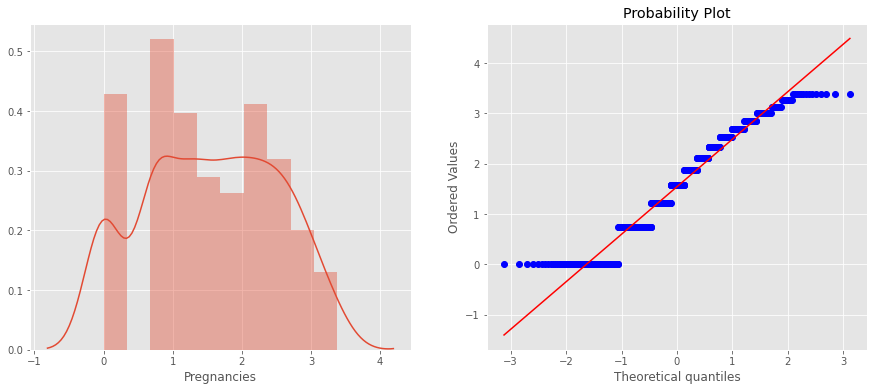

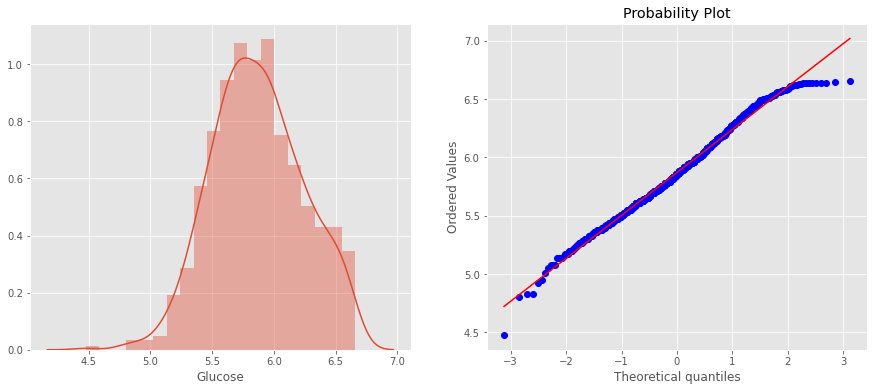

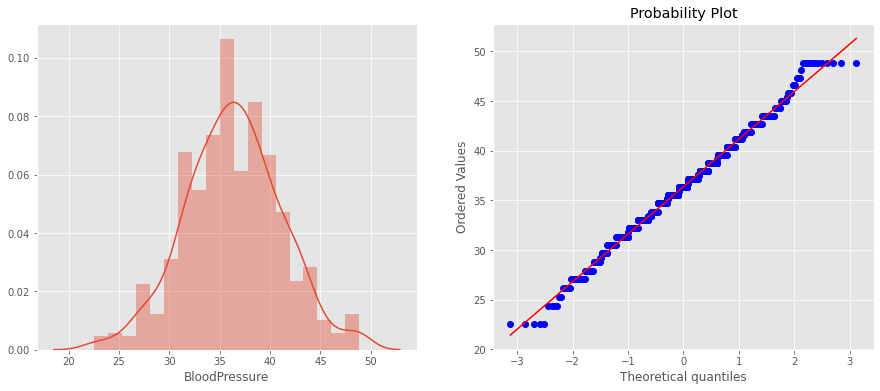

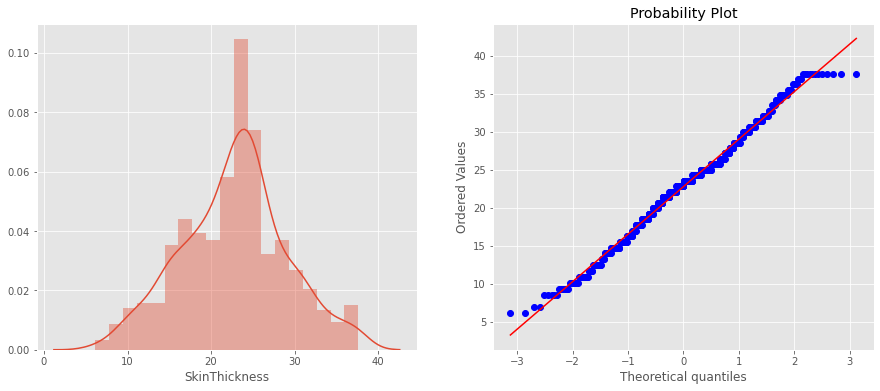

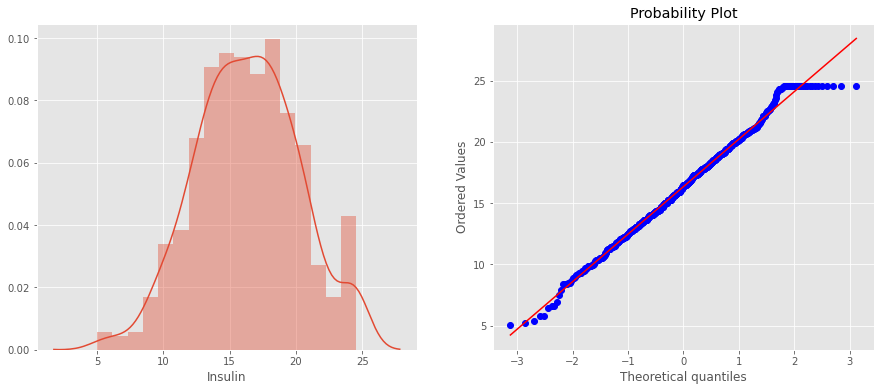

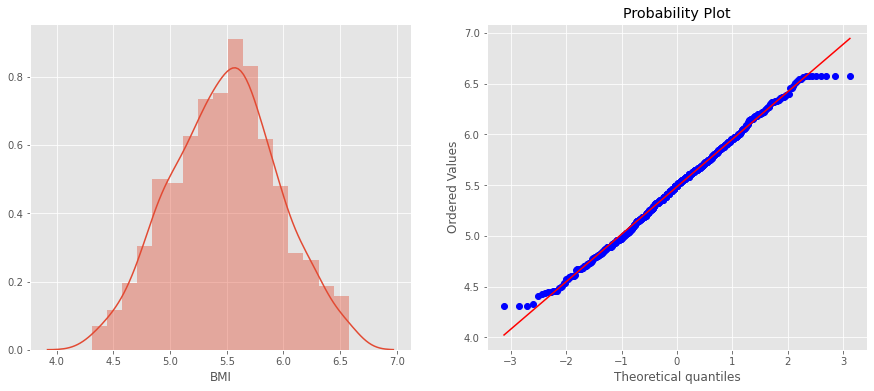

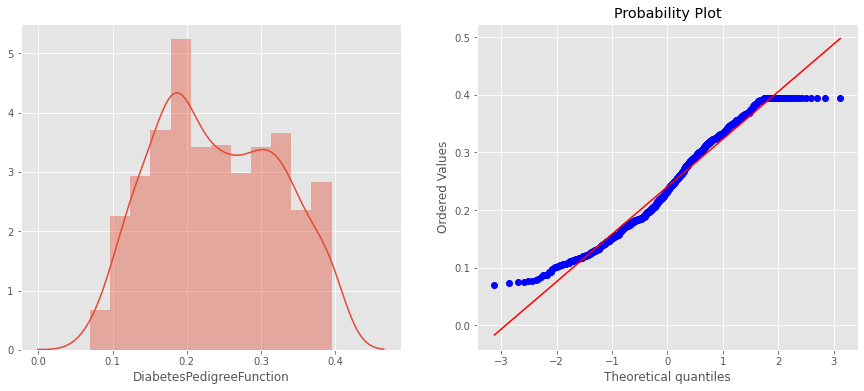

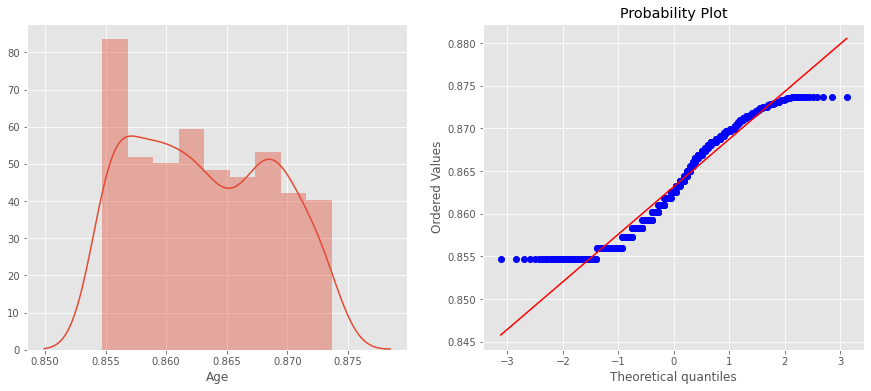

In [33]:
for col in columns:
    diagnostic_plots(data, col)

<a id="model"></a>
## 4) Model Selection and Hyper Parameter Tuning
* Visit ``Model Selection and Hyper Parameter Tuning`` notebook get to know how right parameters are selected and used in this notebook.
* Selected model is **Random Forest Classifer**

In [34]:
#random forest parameters after hyper parameter optimisation.

from sklearn.ensemble import RandomForestClassifier
rfc_params = {'class_weight': 'balanced_subsample',
              'max_depth': 5,
              'max_features': 'log2',
              'min_impurity_decrease': 1e-05,
              'min_samples_leaf': 9,
              'min_samples_split': 2,
              'n_estimators': 7,
              'random_state': 0,
              'n_jobs': -1}

RFC_Model = RandomForestClassifier(**rfc_params)

<a id="feature"></a>
## 5) Feature Selection and Model Evaluation
* Visit ``Feature Selection`` notebook get to know how right parameters are selected and used in this notebook.

* Here we select features by ``Recursive Feature Elimination``

In [35]:
from sklearn.metrics import recall_score,confusion_matrix,classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [36]:
X = data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [37]:
sel = RFE(estimator= RFC_Model, n_features_to_select = 6)
sel.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                     max_depth=5, max_features='log2',
                                     min_impurity_decrease=1e-05,
                                     min_samples_leaf=9, n_estimators=7,
                                     n_jobs=-1, random_state=0),
    n_features_to_select=6)

In [38]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
603,2.522655,6.225257,38.752350,22.854380,15.645104,5.712516,0.324205,0.871799
118,1.867137,5.580920,31.354045,18.475901,12.866988,5.214054,0.259198,0.856033
247,0.000000,6.369532,43.485684,25.725884,24.556112,6.575816,0.253814,0.857217
157,0.738299,5.750825,29.651155,16.994122,16.166911,4.972240,0.349805,0.857217
468,2.695814,5.892249,37.546134,24.294427,17.046939,5.350220,0.142543,0.867347


In [39]:
features = X_train.columns[sel.get_support()]
features #these are the features that are got selected.

Index(['Glucose', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [40]:
X_train_rfe = sel.transform(X_train)
X_test_rfe = sel.transform(X_test)

In [41]:
X_train_rfe = pd.DataFrame(X_train_rfe, columns = features)
X_train_rfe.head()

,Glucose,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.225257,22.854380,15.645104,5.712516,0.324205,0.871799
1,5.580920,18.475901,12.866988,5.214054,0.259198,0.856033
2,6.369532,25.725884,24.556112,6.575816,0.253814,0.857217
3,5.750825,16.994122,16.166911,4.972240,0.349805,0.857217
4,5.892249,24.294427,17.046939,5.350220,0.142543,0.867347


In [42]:
def Run_Classification(model, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Recall_Score: ', recall_score(y_test, y_pred), end='\n\n')
    print('Classification Report :\n', classification_report(y_test, y_pred), end='\n\n')
    print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))

In [43]:
Run_Classification(RFC_Model, X_train_rfe, X_test_rfe)

Recall_Score:  0.8723404255319149

Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       107
           1       0.69      0.87      0.77        47

    accuracy                           0.84       154
   macro avg       0.82      0.85      0.83       154
weighted avg       0.86      0.84      0.85       154


Confusion Matrix :
 [[89 18]
 [ 6 41]]


<a id="roc"></a>
## 6) Model Goodness Check using ROC Curve

Let's check how good our model that we prepared by analysing ROC Curve

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [45]:
predicted_values = pd.DataFrame(RFC_Model.predict_proba(X_test_rfe)[:, 1], columns= ['Predicted_Proba'])
predicted_values.head() #probabilites prediction for +ve diabetes.

,Predicted_Proba
0,0.705430
1,0.290605
2,0.110305
3,0.688262
4,0.275436


In [46]:
predicted_values.shape

(154, 1)

In [47]:
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, predicted_values)
thresholds.shape

(46,)

In [48]:
recall_scores = []
for thres in thresholds:
    y_pred = np.where(predicted_values > thres,1,0)
    recall_scores.append(recall_score(y_test, y_pred))

df = pd.concat([pd.Series(thresholds), pd.Series(recall_scores)], axis=1)
df.columns = ['thresholds', 'Recall_Scores']

df.head()

,thresholds,Recall_Scores
0,1.924154,0.000000
1,0.924154,0.000000
2,0.917649,0.021277
3,0.871375,0.042553
4,0.822669,0.170213


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label= 'NO-Skill')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

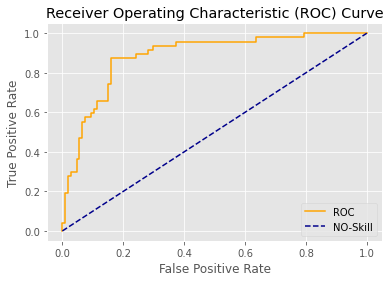

In [50]:
plot_roc_curve(fpr,tpr)

In [51]:
roc_auc_score(y_test, predicted_values.values)

0.8824816066812489

Hence got an better ``Roc Auc Score`` for our model.

<a id="pipeline"></a>
## 7) Pipeline Creation For Prediction

Let's create the pipeline model till what we have done so far.
* Pipeline creates the Whole sequence of processing our model over the raw data after KNN Imputation.

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import recall_score,confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [53]:
#import dataset after knn Imputation.
data = knn_Imp_X.copy()
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,213,33.6,0.627,50
1,1,85,66,29,72,26.6,0.351,31
2,8,183,64,29,214,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [54]:
columns = data.columns
columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [55]:
outlier_df = pd.DataFrame(columns, columns = ['Columns'])
outlier_df

for i, col in enumerate(columns):
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    outlier_df.loc[i, 'Lower_Bound'] = data[col].quantile(0.25)-(IQR*1.5)
    outlier_df.loc[i, 'Upper_Bound'] = data[col].quantile(0.75)+(IQR*1.5)
outlier_df

,Columns,Lower_Bound,Upper_Bound
0,Pregnancies,-6.50,13.50
1,Glucose,39.00,201.00
2,BloodPressure,40.00,104.00
3,SkinThickness,6.50,50.50
4,Insulin,-47.50,332.50
5,BMI,13.85,50.25
6,DiabetesPedigreeFunction,-0.33,1.20
7,Age,-1.50,66.50


In [56]:
X = data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((614, 8), (154, 8))

In [57]:
#random forest parameters after hyper parameter optimisation.
rfc_params = {'class_weight': 'balanced_subsample',
              'max_depth': 5,
              'max_features': 'log2',
              'min_impurity_decrease': 1e-05,
              'min_samples_leaf': 9,
              'min_samples_split': 2,
              'n_estimators': 7,
              'random_state': 0,
              'n_jobs': -1}

RFC_MODEL = RandomForestClassifier(**rfc_params)

In [58]:
#custom Outlier Transformer for making scikit learn pipeline.

class OutliersTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, data, y=None):
        return self
   
    def transform(self, data_, y=None):
        data = data_.copy() #we don't wan't to change the original data.
        
        for i, col in enumerate(columns):
            if col == 'BloodPressure':
                data[col] = np.where(data[col] <= outlier_df.loc[i, 'Lower_Bound'], outlier_df.loc[i, 'Lower_Bound'].astype(int), data[col])
                data[col] = np.where(data[col] >= outlier_df.loc[i, 'Upper_Bound'], outlier_df.loc[i, 'Upper_Bound'].astype(int), data[col])
            elif col not in ['BMI', 'DiabetesPedigreeFunction']:
                data[col] = np.where(data[col] >= outlier_df.loc[i, 'Upper_Bound'], outlier_df.loc[i, 'Upper_Bound'].astype(int), data[col])
            else:
                data[col] = np.where(data[col] >= outlier_df.loc[i, 'Upper_Bound'], outlier_df.loc[i, 'Upper_Bound'], data[col])
    
        return data.values

In [59]:
Pipe_stream = Pipeline([('outlier', OutliersTransformer()), 
                        ('power', PowerTransformer(method = 'yeo-johnson', standardize= False)),
                        ('RFC', RFE(estimator= RFC_MODEL, n_features_to_select = 6)),
                        ('Model', RFC_MODEL)])

In [60]:
Pipe_stream.fit(X_train, y_train)

Pipeline(steps=[('outlier', OutliersTransformer()),
                ('power', PowerTransformer(standardize=False)),
                ('RFC',
                 RFE(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                      max_depth=5,
                                                      max_features='log2',
                                                      min_impurity_decrease=1e-05,
                                                      min_samples_leaf=9,
                                                      n_estimators=7, n_jobs=-1,
                                                      random_state=0),
                     n_features_to_select=6)),
                ('Model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=5, max_features='log2',
                                        min_impurity_decrease=1e-05,
                             

In [61]:

y_pred = Pipe_stream.predict(X_test) #while prediction it only calls the transform method.
print('Recall_Score: ', recall_score(y_test, y_pred), end='\n\n')
print('Classification Report :\n', classification_report(y_test, y_pred), end='\n\n')
print('Confusion Matrix :\n', confusion_matrix(y_test, y_pred))

Recall_Score:  0.8723404255319149

Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.83      0.88       107
           1       0.69      0.87      0.77        47

    accuracy                           0.84       154
   macro avg       0.82      0.85      0.83       154
weighted avg       0.86      0.84      0.85       154


Confusion Matrix :
 [[89 18]
 [ 6 41]]


<a id="run"></a>
### 8) It's Run Time

In [62]:
import numpy as np
a =np.array([6., 148.,  72.,35., 213., 33.6 , 0.627, 50.])
a = np.reshape(a, (1, -1))
a

array([[  6.   , 148.   ,  72.   ,  35.   , 213.   ,  33.6  ,   0.627,
         50.   ]])

In [63]:
a[0]

array([  6.   , 148.   ,  72.   ,  35.   , 213.   ,  33.6  ,   0.627,
        50.   ])

In [64]:
Pipe_stream.predict_proba(pd.DataFrame(a, columns = columns))

array([[0.08945861, 0.91054139]])